# Poisson Kriging - Area to Point Kriging

## Table of Contents:

1. Load areal and point data,
2. Load semivariogram (regularized),
3. Build point-based map of better spatial resolution.

## Level: Advanced

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function | @SimonMolinsky |
| 2021-12-11 | Behavior of `prepare_kriging_data()` function has benn changed | @SimonMolinsky |
| 2021-05-28 | Updated paths for input/output data | @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data. | @SimonMolinsky |

## Introduction

To start this tutorial it is required to understand concepts in the **Ordinary and Simple Kriging** and **Semivariogram Regularization** tutorials. The good idea is to end **Poisson Kriging - Centroid based** and **Poisson Kriging - Area to Area** tutorials before this one.

Poisson Kriging technique is used to model spatial count data. We are analyzing special case where data is counted over areas. Those areas may have irregular shapes and sizes beacuse they represent administrative regions. 

In this tutorial we try to predict rates of Breast Cancer in Pennsylvania counties. Along with areal data we use U.S. Census 2010 data for population blocks.

> Breast cancer rates data is stored in the shapefile in folder `sample_data/areal_data/cancer_data.shp`.

> Population blocks data is stored in the shapefile in folder `sample_data/population_data/cancer_population_base.shp`

This tutorial covers following steps:

1. Read and explore data,
2. Load semivariogram model,
3. Perform Area to Point smoothing of areal data.
4. Visualize points.

## 1) Read and explore data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pyinterpolate.io_ops import prepare_areal_shapefile, get_points_within_area
from pyinterpolate.semivariance import TheoreticalSemivariogram
from pyinterpolate.kriging import ArealKriging

In [2]:
areal_data_file = '../sample_data/areal_data/cancer_data.shp'
point_data_file = '../sample_data/population_data/cancer_population_base.shp'

areal_id_column_name = 'FIPS'
areal_val_column_name = 'rate'
points_val_column_name = 'POP10'


areal_data = prepare_areal_shapefile(areal_data_file,
                                     id_column_name=areal_id_column_name,
                                     value_column_name=areal_val_column_name)
point_data = get_points_within_area(areal_data_file, point_data_file, areal_id_col_name=areal_id_column_name,
                                   points_val_col_name=points_val_column_name)

/Users/szymonmolinski/miniconda3/envs/pyint/lib/python3.7/site-packages/pyinterpolate/io_ops/get_points_within_area.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(output_points_within_area)


<AxesSubplot:>

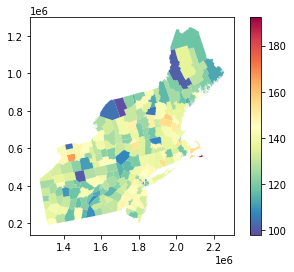

In [3]:
# Lets take a look into a map of areal counts

gdf = gpd.read_file(areal_data_file)
gdf.plot(column='rate', cmap='Spectral_r', legend=True)

#### Clarification: 

It is good idea to look into the spatial patterns in dataset and to visually check if our data do not have any NaN values. We use geopandas GeoDataFrame plot function for it with color map which is diverging color classes well.

## 2) Load semivariogram model

In this step we load regularized semivariogram from the tutorial **Semivariogram Regularization (Intermediate)**. You can always perform semivariogram regulariztion along with the Poisson Kriging but it is a very long process and it is more convenient to separate those two steps.

In [4]:
semivariogram = TheoreticalSemivariogram()  # Create TheoreticalSemivariogram object
semivariogram.import_model('output/regularized_model.csv')  # Load regularized semivariogram

## 3) Perform Area to Point smoothing of areal data.

The process of map smoothing is straightforward. We need to initialize Kriging model then invoke method **regularize_data**. This method takes three parameters:

=> **number of observations** (the most important parameter - how many neighbors are affecting your area of analysis),

=> minimum **search radius** (minimum search radius for analysis from your area of interest, if there are less areas than number of observations then the new, next closest neighbors are included in the analysis),

=> **data_crs** with default **EPSG 4326**.

Method returns GeoDataFrame with points and predicted values. It iteratively re-calculates each area risk and returns predictions per point. In Area to Area Kriging those predictions where aggregated, now we leave them and use them as a smooth map of areal risk.

In [5]:
number_of_obs = 8
radius = 60000  # 60 km

kriging_model = ArealKriging(semivariogram_model=semivariogram,
    known_areas=areal_data,
    known_areas_points=point_data,
    kriging_type='atp')

In [6]:
smoothed_area = kriging_model.regularize_data(number_of_neighbours=number_of_obs,
                                             max_search_radius=radius,
                                             data_crs=gdf.crs)

/Users/szymonmolinski/miniconda3/envs/pyint/lib/python3.7/site-packages/pyinterpolate/transform/prepare_kriging_data.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_arr = np.array([unknown_point_val, otp])
/Users/szymonmolinski/miniconda3/envs/pyint/lib/python3.7/site-packages/pyinterpolate/transform/prepare_kriging_data.py:406: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_data = np.array(points_vals)
/Users/szymonmolinski/miniconda3/envs/pyint/lib/python3.7/site-packages/pyinterpolate/transform/prepare_kriging_data.py:267: Visib

## 4) Visualize data

The last step is data visualization. We use choropleth map from the GeoPandas package, but you can store smoothed map to shapefile of points and process it in a different place or with specific software (in our idea the best for it is **QGIS**).

In [7]:
smoothed_area.head()

,id,geometry,reg.est,reg.err,rmse
0,25019,POINT (2117322.312 556124.507),0.096617,7.599661,28.541554
1,25019,POINT (2134642.820 556124.507),163.561829,7.638901,28.541554
2,36121,POINT (1424501.989 556124.507),5.579363,7.386063,27.346345
3,36121,POINT (1424501.989 546124.507),6.442881,7.631584,27.346345
4,36121,POINT (1433162.243 561124.507),20.087414,7.346801,27.346345


<AxesSubplot:>

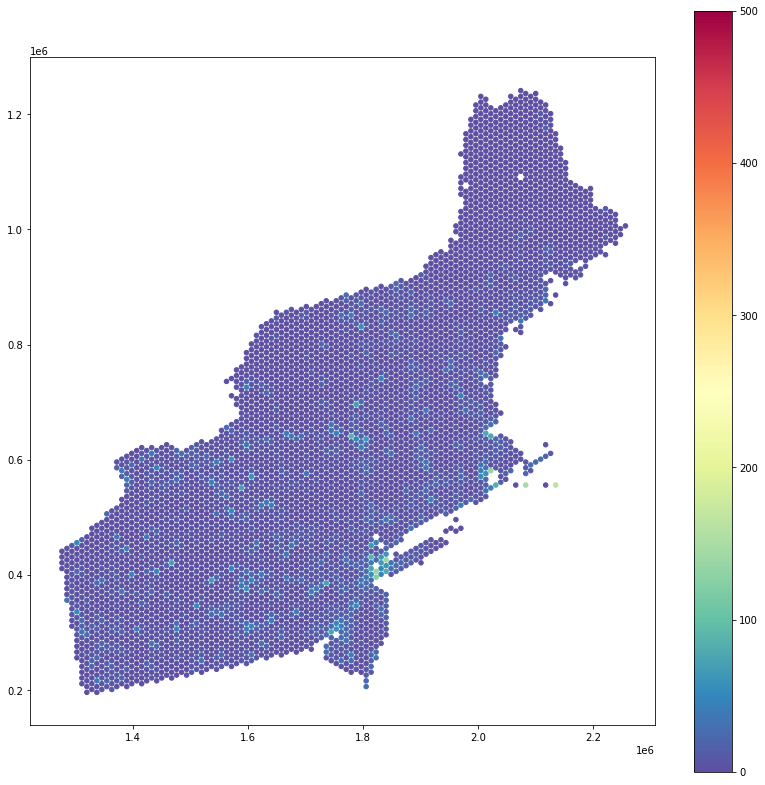

In [8]:
base = gdf.plot(figsize=(14, 14), color='white')
smoothed_area.plot(ax=base, column='reg.est', cmap='Spectral_r', legend=True, markersize=20, vmax=500)

---